In [1]:
import os
import sys
sys.path.append('/home/longshen/work/AccGen/AccGen')
import torch
from models.phrase_vae import load_t5_model_from_lit_ckpt, S2SVQAE
from models.vae_inference import MQAE

ckpt_fp = '/data1/longshen/Results/AccGenResults/bar_compression/s2s/mqcomp_ft/q4_d512_l3_lr1e-4/tb_logs/version_1/checkpoints/epoch=129_step=69420_val_loss=0.0077.ckpt'
t5 = load_t5_model_from_lit_ckpt(ckpt_fp)

model = MQAE()

/home/longshen/programs/miniconda3/envs/accgen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping key model.vq.embedding.weight as it does not start with 'model.t5.'
Skipping key model.vq.embedding.weight as it does not start with 'model.t5.'
Skipping key model.vq.embedding.weight as it does not start with 'model.t5.'
Using compress_style: first_n_tokens


In [2]:
# Prepare tokenizer
from transformers import PreTrainedTokenizerFast
tokenizer_path = 'LongshenOu/phrase-vae-tokenizer'
tok = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)

In [4]:
# Prepare data
from sonata_utils import read_jsonl
jsonl_fp = '/home/longshen/work/AccGen/AccGen/data_preprocess/POP909/statistics/unique_piano_bars.jsonl'
data = read_jsonl(jsonl_fp)
bar1 = data[8]
bar2 = data[108]
print(bar1)
print(bar2)

i-0 o-0 p-30 d-6 o-3 p-66 d-3 p-61 d-3 o-6 p-30 d-3 o-9 p-54 d-3 o-12 p-66 d-3 p-61 d-3 p-30 d-3 o-15 p-54 d-3 o-18 p-66 d-3 p-61 d-3 p-30 d-3 o-21 p-57 d-3 p-30 d-3 o-24 p-66 d-9 p-62 d-9 p-57 d-9 p-38 d-18 p-26 d-6 o-30 p-26 d-6 o-33 p-50 d-6 o-36 p-66 d-6 p-62 d-6 p-57 d-6 p-26 d-3 o-42 p-50 d-6 p-26 d-6 b-1
i-0 o-0 p-35 d-21 o-3 p-42 d-18 o-6 p-47 d-6 o-9 p-54 d-6 o-12 p-63 d-12 o-15 p-47 d-3 o-18 p-59 d-6 o-21 p-54 d-3 o-24 p-34 d-21 o-27 p-51 d-3 o-30 p-54 d-3 o-33 p-51 d-3 o-36 p-61 d-12 o-39 p-51 d-3 o-42 p-54 d-6 o-45 p-51 d-3 b-1


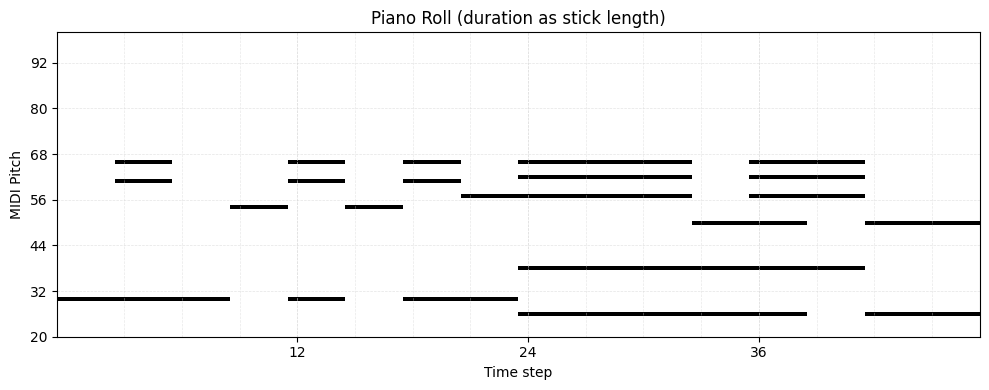

In [5]:
# Draw the two bars
from piano_roll_utils import save_piano_roll
from remi_z import MultiTrack

bar1_mt = MultiTrack.from_remiz_str(bar1)[0]
proll1 = bar1_mt.to_piano_roll(pos_per_bar=48)
save_piano_roll(proll1, 'bar1.png', show=True)

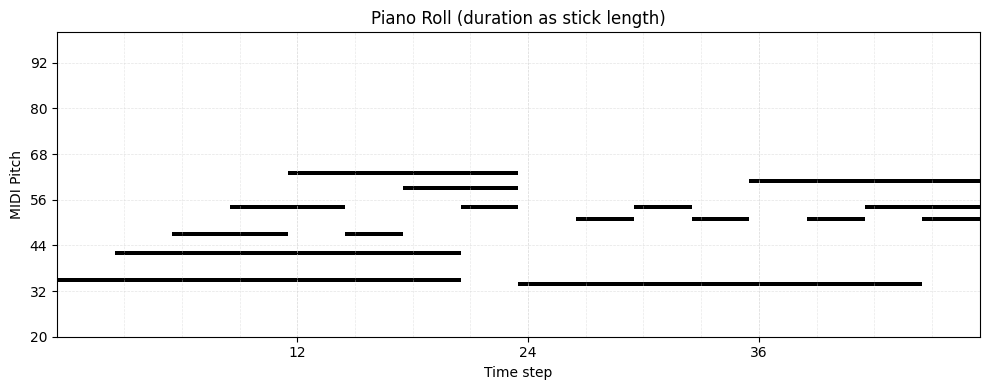

In [5]:
bar2_mt = MultiTrack.from_remiz_str(bar2)[0]
proll2 = bar2_mt.to_piano_roll(pos_per_bar=48)
save_piano_roll(proll2, 'bar2.png', show=True)  

In [6]:
# Get latents of the two bars
def get_latents(model, tok, bar_str):
    # Add special tokens
    inp_seq = bar_str.split()
    inp_seq = ['[BOS]'] + inp_seq + ['[EOS]']
    inp_seq = [f'[C{i}]' for i in range(4)] + inp_seq
    bar_str = ' '.join(inp_seq)

    inputs = tok(bar_str, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
    input_ids = inputs.input_ids
    # Debug: detokenize
    # print(tok.batch_decode(input_ids, skip_special_tokens=False))
    attention_mask = inputs.attention_mask
    with torch.no_grad():
        latents = model.encode(input_ids, attention_mask)
    return latents

latents1 = get_latents(model, tok, bar1)['quantized'][0]
latents2 = get_latents(model, tok, bar2)['quantized'][0]
print(latents1)

tensor([[ 0.3882,  0.0717,  0.0352,  ...,  0.2098, -0.2332,  0.1496],
        [ 0.3833,  0.5305,  0.0655,  ..., -0.1169, -0.2486,  0.1881],
        [ 0.1609,  0.0884, -0.1041,  ..., -0.0293, -0.3032, -0.1777],
        [-0.0165,  0.0502,  0.3361,  ..., -0.0558, -0.4248,  0.2367]])


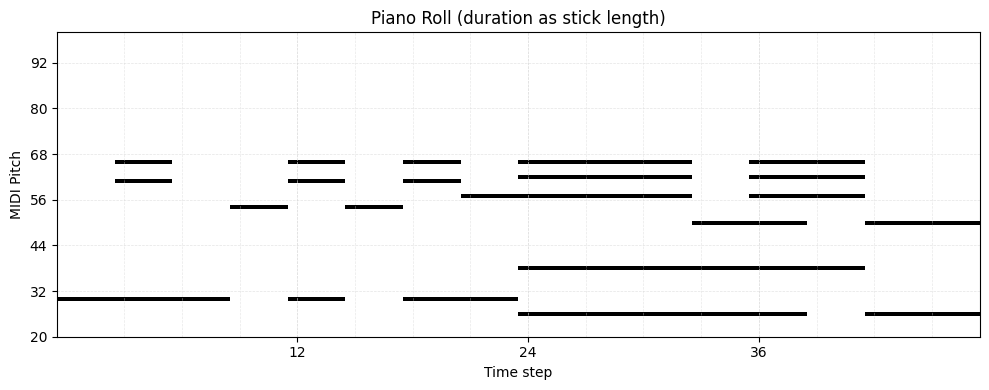

MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar1_recon.mid


In [7]:
def get_piano_roll_from_latents(model, tok, latents):
    out = model.decode(
            {'quantized':latents.unsqueeze(0)},
            max_length=128,
            pad_token_id=tok.pad_token_id,
            eos_token_id=tok.eos_token_id,
            do_sample=False,
            num_beams=1,
        )
    # print(out)
    bar_str = tok.decode(out[0], skip_special_tokens=True)
    # print(bar_str)
    bar_mt = MultiTrack.from_remiz_str(bar_str)[0]
    proll = bar_mt.to_piano_roll(pos_per_bar=48)
    return proll, bar_mt

# Check piano roll reconstruction
proll1_rec, bar_rec = get_piano_roll_from_latents(model, tok, latents1)
save_piano_roll(proll1_rec, 'bar1_rec.png', show=True)
save_dir = '/home/longshen/work/AccGen/AccGen/tests/test_interpolate/'
from sonata_utils import jpath
save_fp = jpath(save_dir, 'bar1_recon.mid')
bar_rec.to_midi(save_fp)


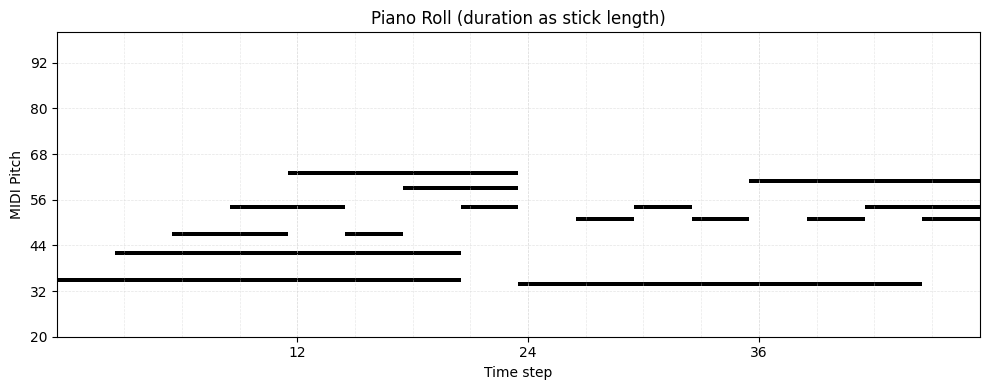

MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar2_recon.mid


In [8]:
# Check reconstructed proll2
proll2_rec, bar2_rec = get_piano_roll_from_latents(model, tok, latents2)
save_piano_roll(proll2_rec, 'bar2_rec.png', show=True)
save_fp = jpath(save_dir, 'bar2_recon.mid')
bar2_rec.to_midi(save_fp)

In [9]:
# Average the two latents
latents_avg = (latents1 + latents2) / 2
proll_avg, bar_avg = get_piano_roll_from_latents(a, tok, latents_avg)
save_piano_roll(proll_avg, 'bar_avg.png', show=True)
bar_avg.to_midi('/home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar_avg.mid')

NameError: name 'a' is not defined

In [ ]:
# Weighted interpolation
weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for w in weights:
    latents_interp = (1-w) * latents1 + w * latents2
    proll_interp, bar_interp = get_piano_roll_from_latents(model, tok, latents_interp)
    save_piano_roll(proll_interp, f'bar_interp_w{w:.1f}.png', show=False)
    bar_interp.to_midi(f'/home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar_interp_w{w:.1f}.mid')

MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar_interp_w0.0.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar_interp_w0.1.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar_interp_w0.2.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar_interp_w0.3.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar_interp_w0.4.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar_interp_w0.5.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar_interp_w0.6.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar_interp_w0.7.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/bar_interp_w0.8.mid
M

In [12]:
# Do for another pair
from sonata_utils import create_dir_if_not_exist
# random select two bar ids
import numpy as np
id1 = np.random.randint(0, len(data))
id2 = np.random.randint(0, len(data))
bar3 = data[id1]
bar4 = data[id2]
save_dir = '/home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair6'
create_dir_if_not_exist(save_dir)

bar3_latents = get_latents(model, tok, bar3)['quantized'][0]
bar4_latents = get_latents(model, tok, bar4)['quantized'][0]

weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for w in weights:
    latents_interp = (1-w) * bar3_latents + w * bar4_latents
    proll_interp, bar_interp = get_piano_roll_from_latents(model, tok, latents_interp)
    proll_fp = jpath(save_dir, f'bar_interp_w{w:.1f}.png')
    midi_fp = jpath(save_dir, f'bar_interp_w{w:.1f}.mid')
    save_piano_roll(proll_interp, proll_fp, show=False)
    bar_interp.to_midi(midi_fp)

MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair6/bar_interp_w0.0.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair6/bar_interp_w0.1.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair6/bar_interp_w0.2.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair6/bar_interp_w0.3.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair6/bar_interp_w0.4.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair6/bar_interp_w0.5.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair6/bar_interp_w0.6.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair6/bar_interp_w0.7.mid
MIDI file successfully written to /home/longshen/work/AccGen/Acc

In [10]:
# Do for another pair
from sonata_utils import create_dir_if_not_exist
bar3 = data[45]
bar4 = data[199]
save_dir = '/home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair4_ex'
create_dir_if_not_exist(save_dir)

bar3_latents = get_latents(model, tok, bar3)['quantized'][0]
bar4_latents = get_latents(model, tok, bar4)['quantized'][0]

weights = [-1, -0.5, 0, 1, 1.5, 2]
for w in weights:
    latents_interp = (1-w) * bar3_latents + w * bar4_latents
    proll_interp, bar_interp = get_piano_roll_from_latents(model, tok, latents_interp)
    proll_fp = jpath(save_dir, f'bar_interp_w{w:.1f}.png')
    midi_fp = jpath(save_dir, f'bar_interp_w{w:.1f}.mid')
    save_piano_roll(proll_interp, proll_fp, show=False)
    bar_interp.to_midi(midi_fp)

MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair4_ex/bar_interp_w-1.0.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair4_ex/bar_interp_w-0.5.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair4_ex/bar_interp_w0.0.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair4_ex/bar_interp_w1.0.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair4_ex/bar_interp_w1.5.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/test_interpolate/pair4_ex/bar_interp_w2.0.mid


In [4]:
from sonata_utils import jpath
from piano_roll_utils import save_piano_roll
# Sample directly
save_dir = '/home/longshen/work/AccGen/AccGen/tests/vae_out/ae_sample_from_normal'
z_random = torch.randn(10, 4, 512)
mts = model.decode_batch(z_random, return_mt=True)
for i, mt in enumerate(mts):
    proll = mt[0].to_piano_roll(pos_per_bar=48)
    save_piano_roll(proll, jpath(save_dir, f'bar_sample_{i}.png'))
    save_fp = jpath(save_dir, f'bar_sample_{i}.mid')
    mt.to_midi(save_fp, tempo=90)

MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/vae_out/ae_sample_from_normal/bar_sample_0.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/vae_out/ae_sample_from_normal/bar_sample_1.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/vae_out/ae_sample_from_normal/bar_sample_2.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/vae_out/ae_sample_from_normal/bar_sample_3.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/vae_out/ae_sample_from_normal/bar_sample_4.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/vae_out/ae_sample_from_normal/bar_sample_5.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/vae_out/ae_sample_from_normal/bar_sample_6.mid
MIDI file successfully written to /home/longshen/work/AccGen/AccGen/tests/vae_out/ae_sample_from_normal/bar_sample_7.mid
MIDI file successfully written t